# LOG6302A — Analyse d’applications et Cyber-sécurité<br>Laboratoire #5

**Quentin Guidée (2206809), Nam Vu (2230468)**

Polytechnique Montréal – Hiver 2024


In [17]:
import tempfile
from collections import defaultdict
from collections.abc import Iterable
from copy import deepcopy
from typing import NamedTuple, Self

from code_analysis import CFG, ASTReader, CFGReader, Graph
from graphviz import Source
from IPython.display import Image
from pydantic import BaseModel

In [18]:
class Pair(NamedTuple):
    def_nid: int
    ref_nid: int


class Taint(BaseModel):
    defs: list[int]
    refs: list[int]
    pairs: list[Pair]
    sinks: list[int]
    filters: list[int]
    safes: list[int]
    sources: list[int]

    @classmethod
    def from_json(cls, taint_file: str) -> Self:
        with open(taint_file, "r") as f:
            taint = cls.model_validate_json(f.read())
        return taint

In [19]:
ast_reader = ASTReader()
cfg_reader = CFGReader()


def show_graph(graph: Graph):
    """Afficher le graphe dans Jupyter"""
    dot = graph.to_dot()
    s = Source(dot)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        s.render(f.name, format="png")
        display(Image(f.name + ".png"))


def show_in_out(
    cfg: CFG,
    taint: Taint,
    in_dict: dict[int, set[int]],
    out_dict: dict[int, set[int]],
):
    """Annote un CFG avec les valeurs de in et out pour chaque noeud puis l'affiche"""
    cfg_copy = deepcopy(cfg)

    for nid in cfg_copy.get_node_ids():
        str_list: list[str] = []

        if (img := cfg_copy.get_image(nid)) is not None:
            str_list.append(img)

        str_list.append(f"in={in_dict[nid]}")
        str_list.append(f"out={out_dict[nid]}")

        if nid in taint.defs:
            str_list.append("[def]")
        if nid in taint.refs:
            str_list.append("[ref]")
        if nid in taint.sources:
            str_list.append("[source]")
        if nid in taint.filters:
            str_list.append("[filter]")
        if nid in taint.safes:
            str_list.append("[safe]")
        if nid in taint.sinks:
            str_list.append("[sink]")

        for pair in taint.pairs:
            if pair.def_nid == nid:
                str_list.append(f"[pair: ref={pair.ref_nid}]")
                break
            if pair.ref_nid == nid:
                str_list.append(f"[pair: def={pair.def_nid}]")
                break

        cfg_copy.set_image(nid, "\n".join(str_list))

    show_graph(cfg_copy)

In [20]:
def get_key(cfg: CFG, nid: int) -> tuple[str, str]:
    return (cfg.get_var_scope(nid), cfg.get_var_id(nid))


class PossiblyTaintedDefinition:
    def __init__(self):
        self.cfg: CFG
        self.taint: Taint

        self.in_dict: dict[int, set[int]]
        self.out_dict: dict[int, set[int]]

        self.visited: set[int]
        self.worklist: list[int]

    def get_gen(self, nid: int) -> set[int]:
        gen_set = set[int]()

        if nid in self.taint.defs:
            children = self.cfg.get_children(nid)
            assert len(children) == 1
            op_nid = children[0]
            assert self.cfg.get_type(op_nid) == "BinOP"
            _, val_nid = self.cfg.get_op_hands(op_nid)
            if self.is_tainted(val_nid):
                gen_set.add(nid)

        if nid in self.taint.sources:
            children = self.cfg.get_children(nid)
            assert len(children) == 1
            def_nid = children[0]
            assert def_nid in self.taint.defs
            gen_set.add(def_nid)

        return gen_set

    def is_tainted(self, nid: int) -> bool:
        match self.cfg.get_type(nid):
            case "Variable":
                assert nid in self.taint.refs
                for def_nid, ref_nid in self.taint.pairs:
                    if ref_nid == nid:
                        return def_nid in self.in_dict[nid]
                else:
                    raise RuntimeError(f"Reference at node {nid} is not paired")
            case "BinOP":
                left_nid, right_nid = self.cfg.get_op_hands(nid)
                return self.is_tainted(left_nid) or self.is_tainted(right_nid)
            case _:
                return False

    def get_kill(self, nid: int) -> set[int]:
        kill_set = set[int]()
        if nid in self.taint.defs:
            nid_key = get_key(self.cfg, nid)
            for other_nid in self.taint.defs:
                if other_nid != nid:
                    other_nid_key = get_key(self.cfg, other_nid)
                    if other_nid_key == nid_key:
                        kill_set.add(other_nid)
        return kill_set

    def pre_loop_init(self) -> Iterable[None]:
        for entry_nid in self.get_entry_node():
            self.in_dict[entry_nid] = set()
            self.visited.add(entry_nid)
            self.worklist.append(entry_nid)
            yield

    def get_entry_node(self) -> Iterable[int]:
        node_ids = self.cfg.get_node_ids()
        for nid in node_ids:
            if self.cfg.get_type(nid) == "Entry":
                yield nid

    def apply_flow_eq(self, nid: int) -> None:
        self.out_dict[nid] = self.get_gen(nid) | (
            self.in_dict[nid] - self.get_kill(nid)
        )

    def next_nodes(self, nid: int) -> Iterable[int]:
        return self.cfg.get_any_children(nid)

    def can_propagate(self, nid: int, next_nid: int) -> bool:
        return (self.out_dict[nid] - self.in_dict[next_nid]) != set()

    def propagate(self, nid: int, next_nid: int) -> None:
        self.in_dict[next_nid] |= self.out_dict[nid]

    def __call__(
        self, cfg: CFG, taint: Taint
    ) -> tuple[dict[int, set[int]], dict[int, set[int]]]:
        self.cfg = cfg
        self.taint = taint

        self.in_dict = defaultdict(set)
        self.out_dict = defaultdict(set)

        self.visited = set()
        self.worklist = []
        for _ in self.pre_loop_init():
            while self.worklist:
                nid = self.worklist.pop()
                self.apply_flow_eq(nid)
                for next_nid in self.next_nodes(nid):
                    if next_nid not in self.visited or self.can_propagate(
                        nid, next_nid
                    ):
                        self.propagate(nid, next_nid)
                        self.worklist.append(next_nid)
                        self.visited.add(next_nid)

        return self.in_dict, self.out_dict


taint_analyzer = PossiblyTaintedDefinition()

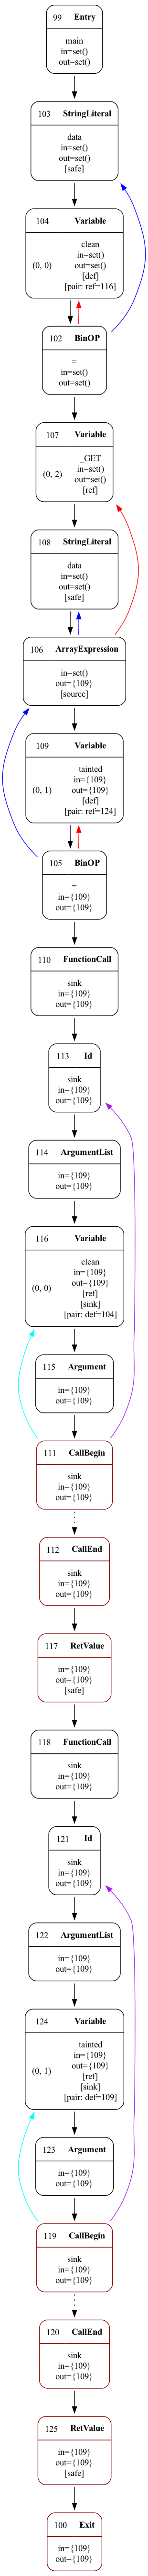

In [21]:
cfg = cfg_reader.read_cfg("../part_1/file_1.php.cfg.json")
taint = Taint.from_json("../part_1/file_1.php.taint.json")
in_dict, out_dict = taint_analyzer(cfg, taint)
show_in_out(cfg, taint, in_dict, out_dict)

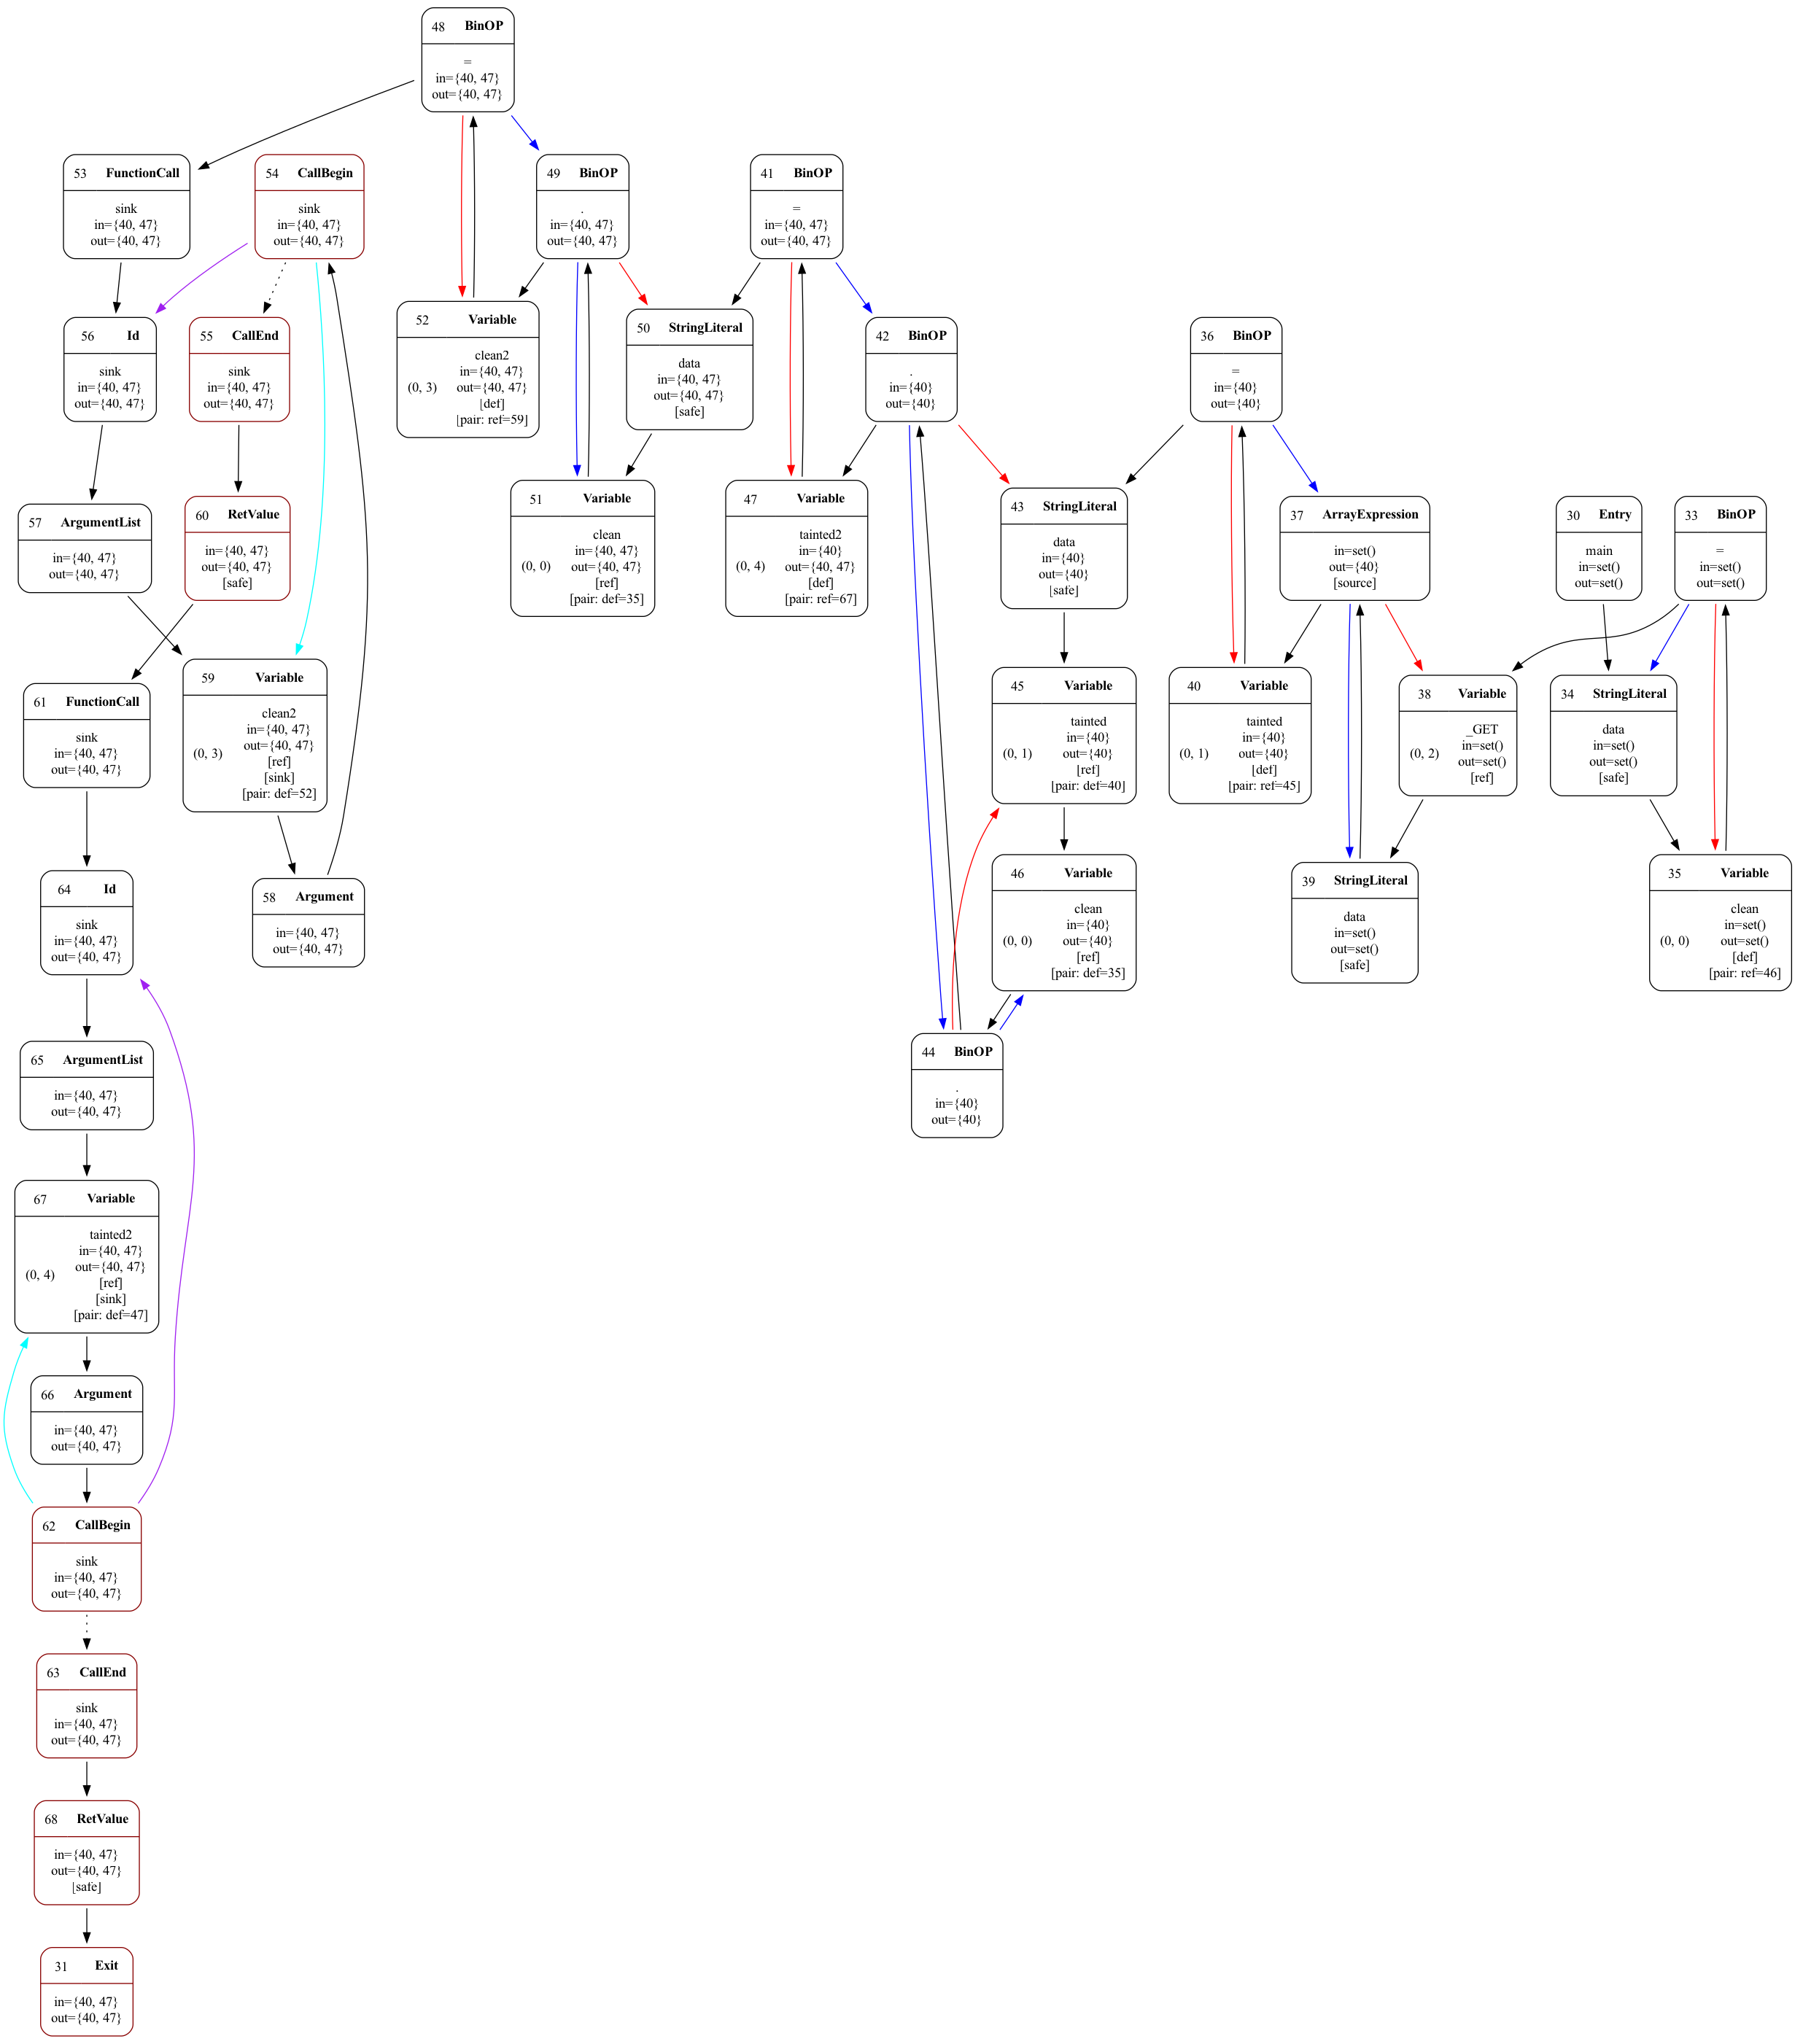

In [22]:
cfg = cfg_reader.read_cfg("../part_1/file_2.php.cfg.json")
taint = Taint.from_json("../part_1/file_2.php.taint.json")
in_dict, out_dict = taint_analyzer(cfg, taint)
show_in_out(cfg, taint, in_dict, out_dict)

In [23]:
def analyze_sinks(php_filename: str):
    print("--------------------")
    print(f"Analyzing {php_filename}")
    print("--------------------")

    cfg = cfg_reader.read_cfg(php_filename + ".cfg.json")
    taint = Taint.from_json(php_filename + ".taint.json")
    in_dict, _ = taint_analyzer(cfg, taint)

    for sink in taint.sinks:
        sink_in = in_dict[sink]
        print(
            f"Sink '{cfg.get_image(sink)}' at line {cfg.get_position(sink)[0]} (node {sink}): in_tainted={sink_in}"
        )

        for pair in taint.pairs:
            if pair.ref_nid == sink:
                print(f"Definition found at node {pair.def_nid}")
                break
        else:
            raise RuntimeError(f"No definition found for sink at node {sink}")

        if pair.def_nid in sink_in:
            print("=> Sink is possibly tainted")
        else:
            print("=> Sink is clean")

        print()

In [24]:
for i in range(1, 6):
    analyze_sinks(f"../part_1/file_{i}.php")

--------------------
Analyzing ../part_1/file_1.php
--------------------
Sink 'clean' at line 5 (node 116): in_tainted={109}
Definition found at node 104
=> Sink is clean

Sink 'tainted' at line 6 (node 124): in_tainted={109}
Definition found at node 109
=> Sink is possibly tainted

--------------------
Analyzing ../part_1/file_2.php
--------------------
Sink 'clean2' at line 8 (node 59): in_tainted={40, 47}
Definition found at node 52
=> Sink is clean

Sink 'tainted2' at line 9 (node 67): in_tainted={40, 47}
Definition found at node 47
=> Sink is possibly tainted

--------------------
Analyzing ../part_1/file_3.php
--------------------
Sink 'clean2' at line 7 (node 28): in_tainted={11}
Definition found at node 21
=> Sink is clean

--------------------
Analyzing ../part_1/file_4.php
--------------------
Sink 'tainted' at line 7 (node 97): in_tainted={76}
Definition found at node 76
=> Sink is possibly tainted

--------------------
Analyzing ../part_1/file_5.php
--------------------
Sin

# Partie 2

In [25]:
import os

for file in os.listdir("../part_2/app.cfg"):
    if file.endswith(".cfg.json"):
        file = file.replace(".cfg.json", "")
        analyze_sinks(f"../part_2/app.cfg/{file}")

--------------------
Analyzing ../part_2/app.cfg/contact.php
--------------------


AssertionError: 